In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plot
import matplotlib.cm as cm
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import mnist
sns.set_palette('husl')
sns.set()
warnings.filterwarnings('ignore')
import pathlib
import os

In [7]:
ds = tfds.load('mnist', with_info=True, shuffle_files=False)
ds_tr = tfds.load('mnist', split='train[:60%]')
ds_t = tfds.load('mnist', split='train[60%:80%]')
ds_val = tfds.load('mnist', split='train[80%:]')

In [8]:
types_names = ds[1].features["label"].names
num_types = len(types_names)
num_examples = ds[1].splits["train"].num_examples
print(num_examples)

60000


Text(0.5, 1.0, 'Bar Plot showing Number of Samples on Each Class')

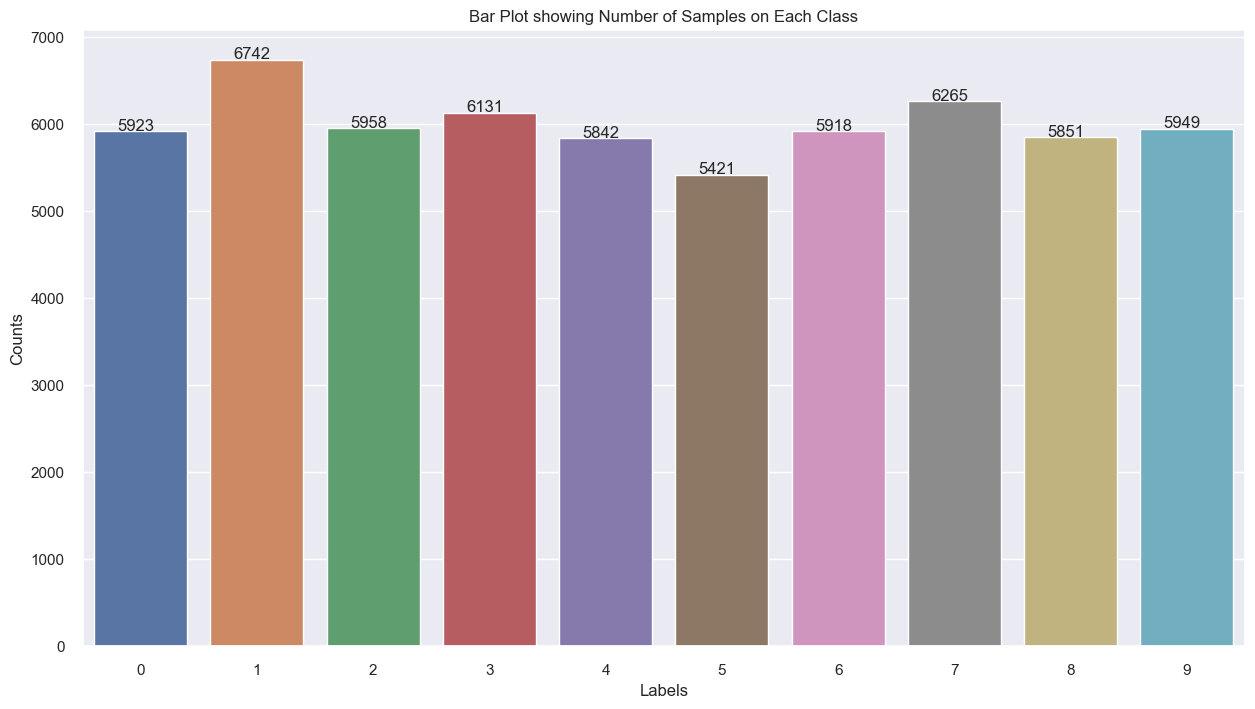

In [9]:
fig, ax = plot.subplots(1, 1, figsize=(15,8))
labels, counts = np.unique(np.fromiter(ds[0]["train"].map(lambda x: x["label"]), np.int32), return_counts=True)

plot.ylabel('Counts')
plot.xlabel('Labels')
sns.barplot(x = [types_names[l] for l in labels], y = counts, ax=ax)
for i, x_ in enumerate(labels):
    ax.text(x_-0.2, counts[i]+5, counts[i])
    
# set the title
ax.set_title("Bar Plot showing Number of Samples on Each Class")

In [10]:
def prepare_for_training(ds, num_types, batch_size=64, shuffle_buffer_size=1000):
    ds = ds.map(lambda d: (d["image"], tf.one_hot(d["label"], num_types)))
    ds = ds.shuffle(buffer_size = shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    return ds

In [11]:
batch_size = 64

ds_tr = prepare_for_training(ds_tr, num_types, batch_size=batch_size)
ds_val = prepare_for_training(ds_val, num_types, batch_size=batch_size)
for elem in ds_val.take(1):
    print(elem[0].shape, elem[1].shape)
for elem in ds_tr.take(1):
    print(elem[0].shape, elem[1].shape)

(64, 28, 28, 1) (64, 10)
(64, 28, 28, 1) (64, 10)


2023-06-11 16:45:13.429789: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-06-11 16:45:13.465463: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [12]:
def show_batch(plot, batch, batch_size):
    plot.figure(figsize=(16, 16))
    for n in range(min(32, batch_size)):
        ax = plot.subplot(batch_size//8, 8, n+1)
        plot.imshow(batch[0][n])
        plot.title(types_names[tf.argmax(batch[1][n].numpy())])
        plot.axis('off')

##### MODEL DEFINITION

- The model consists of three layers, which are arranged sequentially. The first layer, "Flatten", takes the input image data (which has dimensions of 28x28 pixels and one color channel) and flattens it into a one-dimensional array. 

- The second layer is a "Dense" layer with 128 nodes and a ReLU activation function. The ReLU activation function helps to introduce non-linearity into the output, which enables the network to learn complex patterns in the data.

- The final layer is another "Dense" layer, which outputs a probability distribution over the number of classes (which is denoted by "num_types"). This layer uses the "softmax" activation function, which ensures that the output probabilities add up to 1, making them easier to interpret as class probabilities.

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_types, activation='softmax')
])
model.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=[tf.keras.metrics.CategoricalAccuracy('accuracy')])

n_training_steps = int(num_examples * 0.6) // batch_size
n_validation_steps = int(num_examples * 0.2) // batch_size

history = model.fit(ds_tr, validation_data=ds_val, steps_per_epoch=n_training_steps, validation_steps=n_validation_steps, epochs=10, verbose=1)

Epoch 1/10
562/562 [==============================] - 7s 12ms/step - loss: 4.1498 - accuracy: 0.8560 - val_loss: 0.9512 - val_accuracy: 0.8927
Epoch 2/10
562/562 [==============================] - 6s 11ms/step - loss: 0.6445 - accuracy: 0.9156 - val_loss: 0.6161 - val_accuracy: 0.9231
Epoch 3/10
562/562 [==============================] - 6s 11ms/step - loss: 0.4089 - accuracy: 0.9390 - val_loss: 0.5446 - val_accuracy: 0.9347
Epoch 4/10
562/562 [==============================] - 6s 11ms/step - loss: 0.3388 - accuracy: 0.9502 - val_loss: 0.5198 - val_accuracy: 0.9354
Epoch 5/10
562/562 [==============================] - 6s 11ms/step - loss: 0.3007 - accuracy: 0.9574 - val_loss: 0.5428 - val_accuracy: 0.9464
Epoch 6/10
562/562 [==============================] - 6s 11ms/step - loss: 0.2555 - accuracy: 0.9630 - val_loss: 0.6796 - val_accuracy: 0.9439
Epoch 7/10
562/562 [==============================] - 6s 11ms/step - loss: 0.2397 - accuracy: 0.9671 - val_loss: 0.6236 - val_accuracy: 0.9499

Training accuracy is ~97.49%
Validation accuracy is ~95.47%


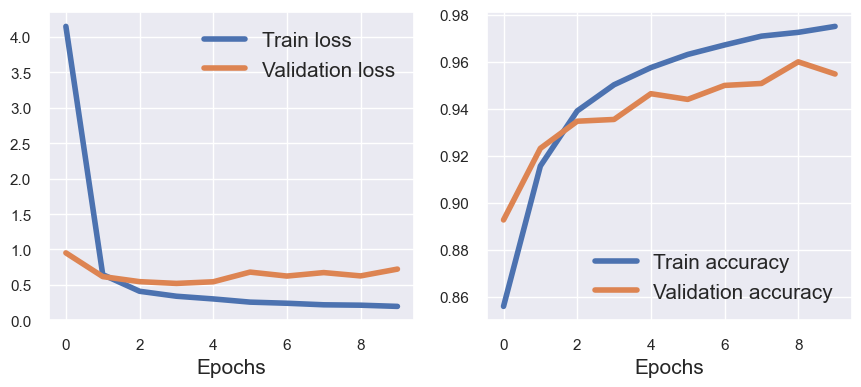

In [14]:
print("Training accuracy is ~{:.2f}%".format(history.history['accuracy'][-1]*100))
print("Validation accuracy is ~{:.2f}%".format(history.history['val_accuracy'][-1]*100))

fig = plot.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plot.plot(history.history['loss'], lw=4)
plot.plot(history.history['val_loss'], lw=4)
plot.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plot.plot(history.history['accuracy'], lw=4)
plot.plot(history.history['val_accuracy'], lw=4)
plot.legend(['Train accuracy', 'Validation accuracy'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

plot.show()


- From the plots above, we see that the model performed better on the training data than it did for the validation data which implies that the model is overfitting. I increased the depths and widths of the layers but they made no significant improvemnets.

#### Test the model

In [15]:
ds_t_size = ds_t.reduce(0, lambda x, _: x+1).numpy()
ds_t_size

12000

In [16]:
# get all testing images as NumPy array
test_images = np.array([d["image"] for d in ds_t.take(ds_t_size)])
print("test_images.shape:", test_images.shape)
# get all testing labels as NumPy array
test_labels = np.array([d["label"] for d in ds_t.take(ds_t_size)])
print("test_labels.shape:", labels.shape)

test_pred = model.predict(test_images)
# perform argmax to get class index
test_pred = np.argmax(test_pred, axis=1)
print("predictions.shape:", test_pred.shape)
diff = test_pred.astype(int) - test_labels.astype(int)
print('accuracy:', len(diff[diff==0])/len(diff)*100, "%")

test_images.shape: (12000, 28, 28, 1)
test_labels.shape: (10,)
375/375 [==============================] - 1s 2ms/step
predictions.shape: (12000,)
accuracy: 95.29166666666666 %


In [17]:
def show_predicted_samples(plot, images, predictions, labels, n_correct=8, n_wrong=8):
    

    df = pd.DataFrame()
    df['pred'] = predictions.astype(int)
    df['label'] = labels.astype(int)
    df['cat'] = 'correct'
    df.loc[(df.pred - df.label!=0), 'cat'] = 'wrong'
    
    plot.figure(figsize=(14, 14))
    correct = df[df.cat=='correct'].iloc[:n_correct, :]
    correct.reset_index(drop=True, inplace=True)
    correct_images = images[df.cat=='correct']
    for n in range(len(correct)):
        ax = plot.subplot(n_correct//2, n_correct - n_correct//2, n + 1)
        # and put the corresponding label as title upper to the image
        # show the image
        plot.imshow(correct_images[n])
        # correct prediction
        ax.set_title(str(correct.pred[n]), color="green")
    plot.axis('off')
    plot.show()


    plot.figure(figsize=(14, 14))
    wrong = df[df.cat=='wrong'].iloc[:n_wrong, :]
    wrong.reset_index(drop=True, inplace=True)
    wrong_images = images[df.cat=='wrong']
    for n in range(len(wrong)):
        ax = plot.subplot(n_wrong//2, n_wrong - n_wrong//2, n+1)
        # and put the corresponding label as title upper to the image
        # show the image
        plot.imshow(wrong_images[n])
        # wrong prediction
        ax.set_title(f"Pred: {str(wrong.pred[n])}/True: {str(wrong.label[n])}", color="red")
    plot.axis('off')
    plot.show()

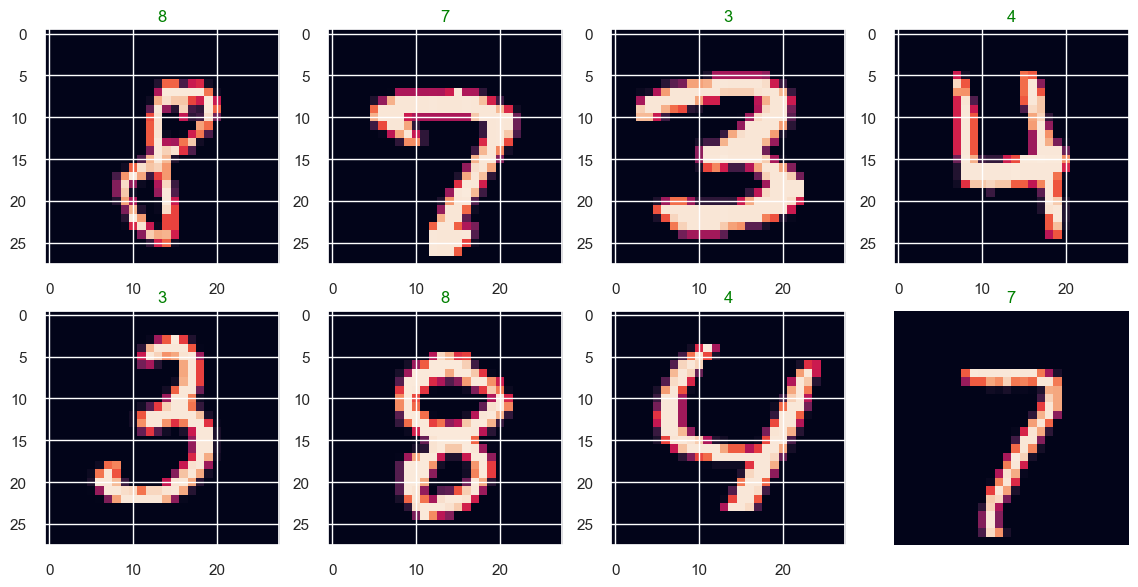

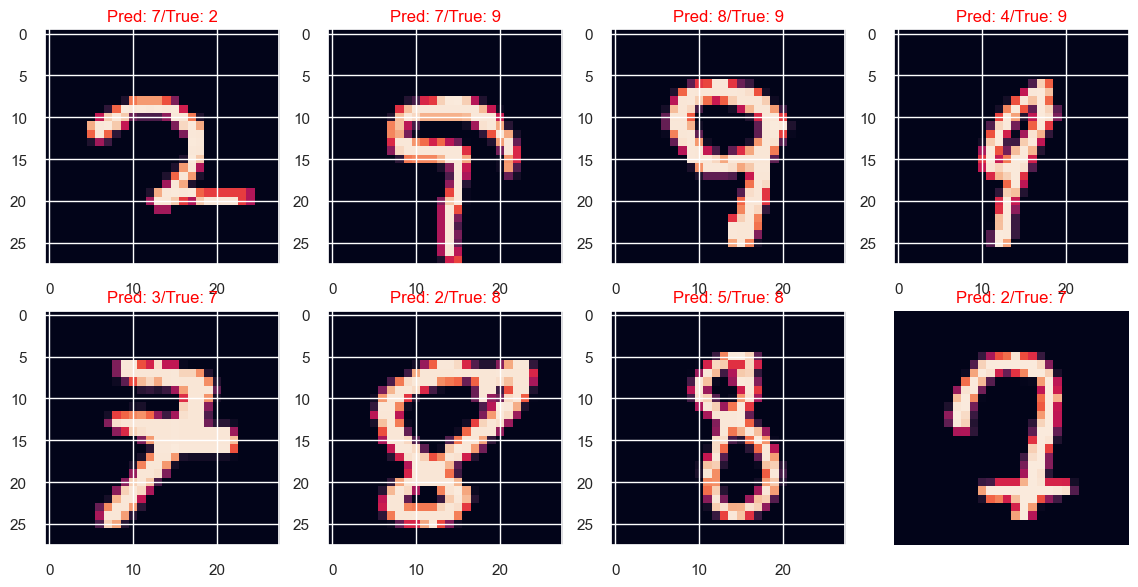

In [18]:
show_predicted_samples(plot, test_images, test_pred, test_labels, n_correct=8, n_wrong=8)

- Based on my observations, there are instances where the model's incorrect predictions are hard for even a human to detect. This indicates that the wrongly classified images, as well as the model's accuracy, fall within an acceptable threshold.

- In summary, it has been justified that this network consisting of a sequence of three layers is a pretty decent model for this handwritten MNIST dataset. 

#### Dropout Layer
- One of the commonly used regularization techniques that can help reduce overfitting is Dropout. Essentially, this technique randomly selects some network weights during the updating process, keeping them fixed to ensure that the network doesn't rely too heavily on a particular subset of nodes. This randomness helps to minimize overfitting by eliminating different neuron subsets dynamically on each observation.

- This can be implemented in Keras by adding a Dropout layer, applied to the output of the layer right before it.

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2, input_shape=(128,)),
    tf.keras.layers.Dense(num_types, activation='softmax')
])
model.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=[tf.keras.metrics.CategoricalAccuracy('accuracy')])

n_training_steps = int(num_examples * 0.6) // batch_size
n_validation_steps = int(num_examples * 0.2) // batch_size

history = model.fit(ds_tr, validation_data=ds_val, steps_per_epoch=n_training_steps,
                    validation_steps=n_validation_steps, epochs=10, verbose=1)

Epoch 1/10
562/562 [==============================] - 7s 12ms/step - loss: 3.9656 - accuracy: 0.7691 - val_loss: 0.7658 - val_accuracy: 0.8612
Epoch 2/10
562/562 [==============================] - 7s 12ms/step - loss: 0.7281 - accuracy: 0.8631 - val_loss: 0.5905 - val_accuracy: 0.9068
Epoch 3/10
562/562 [==============================] - 7s 12ms/step - loss: 0.5901 - accuracy: 0.8973 - val_loss: 0.6074 - val_accuracy: 0.9165
Epoch 4/10
562/562 [==============================] - 7s 12ms/step - loss: 0.5313 - accuracy: 0.9121 - val_loss: 0.5485 - val_accuracy: 0.9260
Epoch 5/10
562/562 [==============================] - 7s 12ms/step - loss: 0.4768 - accuracy: 0.9215 - val_loss: 0.5080 - val_accuracy: 0.9320
Epoch 6/10
562/562 [==============================] - 7s 12ms/step - loss: 0.4411 - accuracy: 0.9266 - val_loss: 0.5812 - val_accuracy: 0.9342
Epoch 7/10
562/562 [==============================] - 7s 12ms/step - loss: 0.4192 - accuracy: 0.9336 - val_loss: 0.7432 - val_accuracy: 0.9342

Training accuracy is ~94.19%
Validation accuracy is ~94.13%


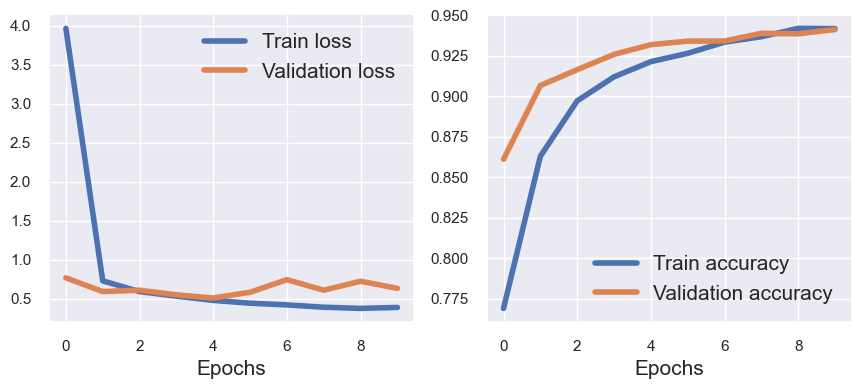

In [20]:
print("Training accuracy is ~{:.2f}%".format(history.history['accuracy'][-1]*100))
print("Validation accuracy is ~{:.2f}%".format(history.history['val_accuracy'][-1]*100))

fig = plot.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plot.plot(history.history['loss'], lw=4)
plot.plot(history.history['val_loss'], lw=4)
plot.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plot.plot(history.history['accuracy'], lw=4)
plot.plot(history.history['val_accuracy'], lw=4)
plot.legend(['Train accuracy', 'Validation accuracy'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

plot.show()

#### Comments
- The dropout layer that was added helped randomly drop out some of the neurons during training, so the model is forced to distribute its learning over multiple neurons. 

- This helped solved the overfitting problem by reducing the model's dependence on a narrow range of features.